In [ ]:
# Nice tutorial on propensity score matching (psm): https://ehsanx.github.io/psw/index.html#description

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
import sqlite3

from streamlit_dashboard.causal_cluster_helper import DataLoader, FollowUpFilter
from psm_helper import PsmHelper, OBSERVATIONAL_CLASSES

import scienceplots

# plt.style.use('science')
plt.style.use('classic')

sns.set()  # set the style

In [3]:
config = configparser.ConfigParser()
config.read('../../data/config/local_config.ini')
conn = sqlite3.connect(config['DATABASE']['path'])

In [4]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 486 (pneumonia)
disease_icd = [("486", "ICD-9"),
               ("J189", "ICD-10")]
title = "Pneumonia(486-J18.9)"
# title = "Pneumonia (ICD-9:486 and ICD-10:J18.9)"
file_name = "pneumonia(486-J189)"

observation_indication_history = [
    ("C0015967", "Fever"),
    ("C0010200", "Coughing"),
    ("C0013404", "Dyspnea"),
    ("C0032285", "Pneumonia"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0332271", "Worsening pattern"),
    ("C0018802", "Congestive heart failure"),
    ("C0239134", "Productive Cough"),
    ("C0019079", "Hemoptysis"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C1145670", "Respiratory Failure"),
    ("C0034063", "Pulmonary Edema"),
    ("C0085593", "Chills"),
    ("C0008034", "Chest Tubes"),
    ("C0004093", "Asthenia"),
    ("C0019682", "HIV"),
    ("C0034642", "Rales"),
    ("C0231835", "Tachypnea"),
    ("C0023518", "Leukocytosis"),
    ("C0476273", "Respiratory distress"),
    ("C0189477", "Thoracentesis"),
    ("C0021107", "Implantation procedure"),
    ("C0700292", "Hypoxemia"),
    ("C0009676", "Confusion"),
    ("C0023890", "Liver Cirrhosis"),
    ("C0039231", "Tachycardia"),
    ("C0043144", "Wheezing"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0032326", "Pneumothorax"),
    ("C0020538", "Hypertensive disease"),
    ("C0000737", "Abdominal Pain"),
    ("C0020649", "Hypotension"),
    ("C4698386", "Intubated"),
    ("C0752151", "Thoracic Surgery, Video-Assisted"),
    ("C0008033", "Pleuritic pain"),
    ("C0007131", "Non-Small Cell Lung Carcinoma"),
    ("C0015672", "Fatigue"),
    ("C0021925", "Intubation (procedure)"),
    ("C0003232", "Antibiotics"),
    ("C0026764", "Multiple Myeloma"),
    ("C0029053", "Decreased translucency"),
    ("C0349707", "Aspiration-action"),
    ("C0013687", "effusion"),
    ("C4086268", "Exacerbation"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C0013216", "Pharmacotherapy"),
    ("C0042963", "Vomiting"),
    ("C0206062", "Lung Diseases, Interstitial"),
    ("C0010068", "Coronary heart disease"),
    ("C0279027", "Laser Therapy, Low-Level"),
    ("C0023530", "Leukopenia"),
    ("C0027497", "Nausea")
]

observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [16]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 511 (pleurisy)
# disease_icd = [("511", "ICD-9")]
disease_icd = [("511", "ICD-9"),
               ("R091", "ICD-10")]
title = "Pleurisy(511-R09.1)"
# title = "Pleurisy (ICD-9:511 and ICD-10:R09.1)"
file_name = "pleurisy(511-R091)"

# drop ("C0032326", "Pneumothorax") since it is only mentioned in CQ in the history section but this is wrongly processed on our side. However, it is not a high frequency disease anymore but only high frequency CQ!!
# ("C0189477", "Thoracentesis"): mostly follow-ups!
# ("C0032285", "Pneumonia"): same as for pneumothorax!
# --------------------------------------------------------------------------------------
# after adapting the code for CQ extraction (now also derive CQ from hx section):
#  - Only the SMD of Pneumothorax is out of range (0.2442)
#    todo: lets have a look in the streamlit dashboard what might be the reason for that!

observation_indication_history = [
    ("C0032227", "Pleural effusion disorder"),
    ("C0008034", "Chest Tubes"),
    ("C0013404", "Dyspnea"),
    ("C0189477", "Thoracentesis"),
    ("C0013687", "effusion"),
    ("C0752151", "Thoracic Surgery, Video-Assisted"),
    ("C0189557", "Pleurodesis"),
    # ("C0032326", "Pneumothorax"),
    ("C0007778", "Cerebral Decortication"),
    ("C4054178", "Pigtail Drain"),
    ("C0023890", "Liver Cirrhosis"),
    ("C0021107", "Implantation procedure"),
    ("C0020312", "Hydrothorax"),
    ("C0039989", "Thoracoscopy"),
    ("C0008031", "Chest Pain"),
    ("C0242184", "Hypoxia"),
    # ("C0032285", "Pneumonia"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C0012621", "Body Fluid Discharge"),
    ("C0278488", "Carcinoma breast stage IV"),
    ("C0039991", "Thoracotomy"),
    ("C0010200", "Coughing"),
    ("C0015967", "Fever"),
    ("C0080032", "Pleural Effusion, Malignant"),
    ("C0332271", "Worsening pattern"),
    ("C0019123", "Hemothorax"),
    ("C0018802", "Congestive heart failure"),
    ("C5237755", "Recurrent Large Pleural Effusion"),
    ("C0020303", "Hydropneumothorax"),
    ("C0006142", "Malignant neoplasm of breast"),
    ("C0189476", "Insertion of pleural tube drain"),
    ("C0007131", "Non-Small Cell Lung Carcinoma"),
    ("C0019196", "Hepatitis C"),
    ("C0010055", "Coronary Artery Bypass Surgery"),
    ("C0014009", "Empyema"),
    ("C0153676", "Secondary malignant neoplasm of lung"),
    ("C0008033", "Pleuritic pain"),
    ("C0176531", "Biopsy of pleura (procedure)"),
    ("C1145670", "Respiratory Failure"),
    ("C0879203", "Pigtail Catheters"),
    ("C0023891", "Liver Cirrhosis, Alcoholic"),
    ("C0034063", "Pulmonary Edema"),
    ("C0278883", "Metastatic melanoma"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0035234", "Respiratory Sounds"),
    ("C0231835", "Tachypnea"),
    ("C0010068", "Coronary heart disease"),
    ("C0030899", "pentoxifylline"),
    ("C0018944", "Hematoma"),
    ("C0019682", "HIV"),
    ("C0225778", "Pleural fluid"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0007134", "Renal Cell Carcinoma"),
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [36]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 428, I50 (Heart failure)
disease_icd = [("428", "ICD-9"),
               ("I50", "ICD-10")]
title = "Heart failure(428-I50)"
# title = "Heart failure (ICD-9:428 and ICD-10:I50)"
file_name = "heart_failure(428-I50)"

# drop ("C0032285", "Pneumonia") since it is only mentioned in CQ in the history section but this is wrongly processed on our side. However, it is not a high frequency disease anymore but only high frequency CQ!!
# drop ("C0034063", "Pulmonary Edema") party manually observed as CQ or as follow-up (e.g. interval change, ...). But here, wrongly automatically classified as indication/history!!

observation_indication_history = [
    ("C0013404", "Dyspnea"),
    ("C0018802", "Congestive heart failure"),
    ("C0242184", "Hypoxia"),
    ("C0010200", "Coughing"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0008031", "Chest Pain"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    # ("C0032285", "Pneumonia"),
    ("C0018801", "Heart failure"),
    # ("C0034063", "Pulmonary Edema"),
    ("C0332271", "Worsening pattern"),
    ("C0010068", "Coronary heart disease"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0021107", "Implantation procedure"),
    ("C0020725", "Type II Mucolipidosis"),
    ("C0020538", "Hypertensive disease"),
    ("C0015967", "Fever"),
    ("C0013604", "Edema"),
    ("C0003507", "Aortic Valve Stenosis"),
    ("C0264716", "Chronic heart failure"),
    ("C0010055", "Coronary Artery Bypass Surgery"),
    ("C0022661", "Kidney Failure, Chronic"),
    ("C0013687", "effusion"),
    ("C0036980", "Shock, Cardiogenic"),
    ("C0043094", "Weight Gain"),
    ("C0034642", "Rales"),
    ("C0189477", "Thoracentesis"),
    ("C0476273", "Respiratory distress"),
    ("C0231807", "Dyspnea on exertion"),
    ("C0546817", "Fluid overload"),
    ("C0012797", "Diuresis"),
    ("C0239340", "Edema of lower extremity"),
    ("C0878544", "Cardiomyopathies"),
    ("C0700292", "Hypoxemia"),
    ("C0008034", "Chest Tubes"),
    ("C1145670", "Respiratory Failure"),
    ("C0030163", "Artificial cardiac pacemaker"),
    ("C0004093", "Asthenia"),
    ("C0020649", "Hypotension"),
    ("C0023518", "Leukocytosis"),
    ("C0085619", "Orthopnea"),
    ("C0020542", "Pulmonary Hypertension"),
    ("C0015672", "Fatigue"),
    ("C0179790", "Pulmonary artery flotation catheter"),
    ("C0239134", "Productive Cough"),
    ("C0019829", "Hodgkin Disease"),
    ("C0032326", "Pneumothorax"),
    ("C0004096", "Asthma"),
    ("C0043144", "Wheezing"),
    ("C1561643", "Chronic Kidney Diseases"),
    ("C4698386", "Intubated"),
    ("C0179740", "Peripherally inserted central catheter (physical object)"),
    ("C1135196", "Heart Failure, Diastolic"),
    ("C0020488", "Hypernatremia"),
    ("C0021925", "Intubation (procedure)"),
    ("C0010054", "Coronary Arteriosclerosis"),
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [44]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]

# for icd-code disease: 807, S22 (Rip fracture)
disease_icd = [("807", "ICD-9"),
               ("S22", "ICD-10")]
title = "Rib fracture(807-S22)"
# title = "Rib fracture (ICD-9:807 and ICD-10:S22)"
file_name = "rib_fracture(807-S22)"

observation_indication_history = [
    ("C0035522", "Rib Fractures"),
    ("C0032326", "Pneumothorax"),
    ("C0008034", "Chest Tubes"),
    ("C1421211", "GFUS gene"),  # most mentioned by 'fx' which means fracture
    ("C0030899", "pentoxifylline"),  # not a drug but mostly referred to 'ptx' which stands for pneumothorax
    ("C0019123", "Hemothorax"),
    ("C0043251", "Wounds and Injuries"),
    ("C0013404", "Dyspnea"),
    ("C0242184", "Hypoxia"),
    ("C0008031", "Chest Pain"),
    ("C0026771", "Multiple Trauma"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0085639", "Falls"),
    ("C0021107", "Implantation procedure"),
    ("C0238436", "Fracture of sternum"),
    ("C0000932", "Traffic accidents"),
    ("C0032285", "Pneumonia"),
    ("C4698386", "Intubated"),
    ("C0019077", "Hemopneumothorax"),
    ("C0030193", "Pain"),
    ("C0016658", "Fracture")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [28]:
treatment_var = "is_clinical_question_stated"
patient_characteristics = [
    "age_intervall_0",
    "age_intervall_1",
    "age_intervall_2",
    "M",
    "F"
]
# streamlit query for "ICD-Code input": ^490|^491|^492|^493|^494|^495|^496|^497|^J40|^J41|^J42|^J43|^J44|^J45|^J46|^J47
# for icd-code disease: Chronic obstructive pulmonary disease and bronchiectasis
disease_icd = [("490", "ICD-9"),
               ("491", "ICD-9"),
               ("492", "ICD-9"),
               ("493", "ICD-9"),
               ("494", "ICD-9"),
               ("495", "ICD-9"),
               ("496", "ICD-9"),
               ("J40", "ICD-10"),
               ("J41", "ICD-10"),
               ("J42", "ICD-10"),
               ("J43", "ICD-10"),
               ("J44", "ICD-10"),
               ("J45", "ICD-10"),
               ("J46", "ICD-10"),
               ("J47", "ICD-10")]

title = "COPD and bronchiectasis(490-497 and J40-J47)"
# title = "COPD and bronchiectasis (ICD-9:490-497 and ICD-10:J40-J47)"
file_name = "copd_and_bronchiectasis(490-497 and J40-J47)"

observation_indication_history = [
    ("C0013404", "Dyspnea"),
    ("C0024117", "Chronic Obstructive Airway Disease"),
    ("C0010200", "Coughing"),
    ("C0004096", "Asthma"),
    ("C4086268", "Exacerbation"),
    ("C0242184", "Hypoxia"),
    ("C0015967", "Fever"),
    # ("C0032285", "Pneumonia"),
    ("C0043144", "Wheezing"),
    ("C0008031", "Chest Pain"),
    # ("C0349588", "Short stature"),  # should be "shortness of breath" as by exploratory analysis
    ("C0239134", "Productive Cough"),
    ("C0018802", "Congestive heart failure"),
    ("C0332271", "Worsening pattern"),
    ("C0476273", "Respiratory distress"),
    ("C0349790", "Exacerbation of asthma"),
    # ("C0032326", "Pneumothorax"),
    # ("C0015264", "Exertion"),  # maybe keep this
    # ("C0600500", "Peptide Nucleic Acids"),  # should be the abbreviation of "pneumonia" and not "Peptide Nucleic Acids"
    ("C1145670", "Respiratory Failure"),
    ("C0008034", "Chest Tubes"),
    # ("C0225386", "Breath"),  # should be "shortness of breath"
    ("C0231835", "Tachypnea"),
    ("C0021925", "Intubation (procedure)"),
    ("C0020538", "Hypertensive disease"),
    ("C0242379", "Malignant neoplasm of lung"),
    ("C0021107", "Implantation procedure"),
    ("C0019079", "Hemoptysis"),
    ("C0034642", "Rales"),
    ("C0085593", "Chills"),
    ("C0038056", "Sputum"),
    ("C4698386", "Intubated"),
    ("C0349707", "Aspiration-action"),
    ("C0010068", "Coronary heart disease"),
    ("C0023518", "Leukocytosis"),
    ("C0006267", "Bronchiectasis"),
    ("C0039231", "Tachycardia"),
    ("C0034063", "Pulmonary Edema"),
    ("C0019682", "HIV"),
    ("C0035234", "Respiratory Sounds"),
    ("C0030054", "oxygen"),
    ("C1514873", "Requirement"),
    ("C0455544", "H/O: asthma"),
    ("C0004238", "Atrial Fibrillation"),
    ("C0700292", "Hypoxemia"),
    ("C0242104", "Sputum production"),
    ("C0008033", "Pleuritic pain"),
    ("C0032227", "Pleural effusion disorder"),
    ("C0175730", "biomedical tube device"),
    ("C0264558", "Tension Pneumothorax"),
    ("C0746961", "Oxygen saturation below reference range"),
    ("C1517205", "Flare"),
    ("C0232292", "Chest tightness"),
    ("C0036202", "Sarcoidosis"),
    ("C0278060", "Mental state"),
    ("C0001623", "Adrenal gland hypofunction"),
    ("C0035508", "Rhonchi"),
    ("C4528581", "Endobronchial Stent Placement"),
    ("C0013604", "Edema"),
    ("C0004093", "Asthenia"),
    ("C0020440", "Hypercapnia"),
    ("C0231807", "Dyspnea on exertion"),
    ("C0850149", "Dry cough"),
    ("C0562483", "Persistent cough")
]
observation_indication_history_cuis = [x[0] for x in observation_indication_history]
observation_indication_history = observation_indication_history[:15]
observation_indication_history_cuis = observation_indication_history_cuis[:15]

In [5]:
%%time
# load psm data
df_data_orig = DataLoader.load_data(conn, OBSERVATIONAL_CLASSES)

load_data()
select t1.*, t4.gender, t4.anchor_age, t4.anchor_year, t2.icd_code, t3.indic_filtered, t3.indication_cuis, t3.clinical_question, t3.clinical_q_cuis, t3.hist_finished, t3.history_cuis, t3.comparison, t3.comparison_cuis from streamlit_timeline_data t1 left join diagnoses_icd t2 on t1.hadm_id = t2.hadm_id left join referral_information_v2 t3 on t1.study_id = t3.study left join patients t4 on t1.subject_id = t4.subject_id where t2.seq_num <= 1;
CPU times: user 15.5 s, sys: 4.26 s, total: 19.7 s
Wall time: 22.1 s


In [45]:
df_data = df_data_orig.copy(deep=True)

In [8]:
df_data.head()

,False,subject_id,study_id,stay_id,hadm_id,process_id,timeline_id,datetime_start,datetime_end,process_type,...,Enlarged_Cardiomediastinum_is_stated,Fracture_is_stated,Lung_Lesion_is_stated,Lung_Opacity_is_stated,No_Finding_is_stated,Pleural_Effusion_is_stated,Pleural_Other_is_stated,Pneumonia_is_stated,Pneumothorax_is_stated,Support_Devices_is_stated
0,6645,10292289,58864150,-1,24407534,58864150,h_24407534,2172-09-06 12:16:44,2172-09-06 13:16:44,xray,...,0,0,0,0,0,1,0,0,1,1
2,124814,15468931,50206196,-1,24880826,50206196,h_24880826,2172-06-02 00:41:32,2172-06-02 01:41:32,xray,...,0,0,0,0,0,1,0,0,1,1
3,124815,15468931,56818113,-1,24880826,56818113,h_24880826,2172-06-03 02:31:21,2172-06-03 03:31:21,xray,...,1,0,0,0,0,1,0,0,1,0
5,54185,12379465,52511772,-1,24261904,52511772,h_24261904,2141-05-03 15:59:40,2141-05-03 16:59:40,xray,...,0,0,0,0,0,0,0,0,1,1
6,54187,12379465,52579804,-1,24261904,52579804,h_24261904,2141-05-01 18:50:50,2141-05-01 19:50:50,xray,...,0,0,0,0,0,1,0,0,1,1


In [38]:
df_lookup_data = pd.read_sql("select * from referral_information_cui_lookup", conn)

NR_BINS_HIST = 100
psm_helper_tmp = PsmHelper(data=df_data,
                           patient_characteristics=None,
                           custom_confounders=[],
                           indication_cuis=None,
                           treatment_var=treatment_var,
                           spec_cq_cui=None)
psm_helper_tmp.filter_by_disease_icd_code(disease_icd)
df_cluster_1 = psm_helper_tmp.data_filtered
df_exploded_cluster_1 = df_cluster_1.explode("indication_history_cuis")
df_referral_stats_cluster_1 = df_exploded_cluster_1["indication_history_cuis"].value_counts().iloc[:NR_BINS_HIST]
df_hist_lookup_cluster_1 = pd.merge(df_referral_stats_cluster_1, df_lookup_data, how="left", left_index=True,
                                    right_on="CUI")
df_hist_lookup_cluster_1 = df_hist_lookup_cluster_1.reset_index(drop=True)
df_hist_lookup_cluster_1.rename(columns={"indication_history_cuis": "count"}, inplace=True)
df_hist_lookup_cluster_1[["CUI", "Name", "count"]]

,CUI,Name,count
0,no_note,NaN,7297
1,C0013404,Dyspnea,2245
2,C0439234,year,2191
3,C0043210,Woman,2033
4,C0018802,Congestive heart failure,1584
...,...,...,...
95,C0302908,Liquid substance,36
96,C0348011,Surgical transfer - action,34
97,C0038454,Cerebrovascular accident,34
98,C0231835,Tachypnea,34


In [39]:
cnt_lowest_considered_confounder = df_hist_lookup_cluster_1[df_hist_lookup_cluster_1["Name"] == observation_indication_history[-1][1]].iloc[0]["count"]
lowest_cons_perc = cnt_lowest_considered_confounder*100./psm_helper_tmp.data_filtered.shape[0]
print(f"For diseases [{title}]")
print("Occurrence frequency of the lowest considered confounder: %.2f%%" % lowest_cons_perc)

For diseases [Heart failure(428-I50)]
Occurrence frequency of the lowest considered confounder: 1.88%


In [45]:
df_cluster_1.head()

,False,subject_id,study_id,stay_id,hadm_id,process_id,timeline_id,datetime_start,datetime_end,process_type,...,Enlarged_Cardiomediastinum_is_stated,Fracture_is_stated,Lung_Lesion_is_stated,Lung_Opacity_is_stated,No_Finding_is_stated,Pleural_Effusion_is_stated,Pleural_Other_is_stated,Pneumonia_is_stated,Pneumothorax_is_stated,Support_Devices_is_stated
0,224399,19845148,54911068,-1,21525925,54911068,h_21525925,2145-02-22 23:31:41,2145-02-23 00:31:41,xray,...,0,0,0,1,0,1,0,1,1,1
1,34029,11529295,52264181,-1,28359200,52264181,h_28359200,2182-05-08 17:44:03,2182-05-08 18:44:03,xray,...,0,0,0,1,0,1,0,0,1,0
2,37084,11649885,54121777,-1,27738102,54121777,h_27738102,2165-01-07 13:13:59,2165-01-07 14:13:59,xray,...,0,0,0,0,0,0,0,0,0,0
3,158500,16957952,57798090,35733215,25043837,57798090,h_25043837,2168-11-19 04:50:44,2168-11-19 05:50:44,xray,...,0,0,0,0,0,0,0,1,0,0
4,116510,15129969,57015276,30001727,25807616,57015276,h_25807616,2127-09-28 11:36:26,2127-09-28 12:36:26,xray,...,1,0,1,1,0,1,0,0,0,0


In [10]:
df_exploded_cluster_cq_1 = df_cluster_1[df_cluster_1["Atelectasis_is_stated"] == 1].explode("clinical_q_cuis")
df_exploded_cluster_cq_2 = df_cluster_1[df_cluster_1["Atelectasis_is_stated"] == 0].explode("clinical_q_cuis")

df_cq_stats_cluster_1 = df_exploded_cluster_cq_1["clinical_q_cuis"].value_counts().iloc[:NR_BINS_HIST]
df_cq_stats_cluster_2 = df_exploded_cluster_cq_2["clinical_q_cuis"].value_counts().iloc[:NR_BINS_HIST]

df_cq_lookup_cluster_1 = pd.merge(df_cq_stats_cluster_1, df_lookup_data, how="left", left_index=True,
                                    right_on="CUI")
df_cq_lookup_cluster_2 = pd.merge(df_cq_stats_cluster_2, df_lookup_data, how="left", left_index=True,
                                    right_on="CUI")
df_cq_lookup_cluster_1 = df_cq_lookup_cluster_1.reset_index(drop=True)
df_cq_lookup_cluster_2 = df_cq_lookup_cluster_2.reset_index(drop=True)

df_cq_lookup_cluster_1.rename(columns={"clinical_q_cuis": "count"}, inplace=True)
df_cq_lookup_cluster_2.rename(columns={"clinical_q_cuis": "count"}, inplace=True)

print(df_cq_lookup_cluster_1[["CUI", "Name", "count"]])
print(df_cq_lookup_cluster_2[["CUI", "Name", "count"]])

               CUI                       Name  count
0          no_note                        NaN    360
1   entity_unknown                        NaN    177
2         C0220825                 Evaluation    154
3         C0032285                  Pneumonia    111
4         C1272706                   Interval     74
..             ...                        ...    ...
95        C0242184                    Hypoxia      2
96        C0235974       Pancreatic carcinoma      2
97        C0349588              Short stature      1
98        C0278488  Carcinoma breast stage IV      1
99        C4697762   acute infectious process      1

[100 rows x 3 columns]
               CUI           Name  count
0          no_note            NaN    954
1         C0220825     Evaluation    452
2         C0032285      Pneumonia    376
3   entity_unknown            NaN    337
4         C1272706       Interval    169
..             ...            ...    ...
95        C0744689     heart size      3
96        C0

In [39]:
df_cluster_1[df_cluster_1["Atelectasis_is_stated" == 1]]

KeyError: False

In [30]:
df_exploded_cluster_cq = df_cluster_1.explode("clinical_q_cuis")
df_cq_stats_cluster_1 = df_exploded_cluster_cq["clinical_q_cuis"].value_counts().iloc[:NR_BINS_HIST]
df_cq_lookup_cluster_1 = pd.merge(df_cq_stats_cluster_1, df_lookup_data, how="left", left_index=True,
                                    right_on="CUI")
df_cq_lookup_cluster_1 = df_cq_lookup_cluster_1.reset_index(drop=True)
df_cq_lookup_cluster_1

,clinical_q_cuis,CUI,Name
0,2669,no_note,NaN
1,1465,entity_unknown,NaN
2,1406,C0220825,Evaluation
3,844,C0034063,Pulmonary Edema
4,569,C0032285,Pneumonia
...,...,...,...
95,11,C0242073,Pulmonary congestion
96,11,C0030664,Pathology
97,10,C1519955,Vascular Access Device Placement
98,9,C0008031,Chest Pain


In [46]:
# follow-up filter
follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                    "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 1000}
# init psm helper
psm_helper = PsmHelper(data=df_data,
                       patient_characteristics=patient_characteristics,
                       custom_confounders=[],
                       indication_cuis=observation_indication_history_cuis,
                       treatment_var=treatment_var,
                       spec_cq_cui=None,
                       follow_up_filter=None)
# follow_up_filter=follow_up_filter)
psm_helper.generate_psm_data(icd_code=disease_icd,
                             apply_cond_filter=False)  # if filter == True: only keep entries with at least one entry from observation_indication_history !!

(975, 63)


In [12]:
psm_helper.data_psm

,level_0,index,is_clinical_question_stated,C0015967,C0010200,C0013404,C0032285,C0242184,C0008031,C0032227,...,Pleural_Effusion_is_stated,Pleural_Other_is_stated,Pneumonia_is_stated,Pneumothorax_is_stated,Support_Devices_is_stated,F,M,age_intervall_0,age_intervall_1,age_intervall_2
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,3,3,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,4,4,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,3073,3073,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
3074,3074,3074,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
3075,3075,3075,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3076,3076,3076,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [47]:
# follow-up filter
follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                    "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 1000}  # MIN_EXAMS_DURING_UNIQUE_HADM_ID -> legacy, not used anymore
# init psm helper
psm_helper_fu = PsmHelper(data=df_data,
                          patient_characteristics=patient_characteristics,
                          custom_confounders=[],
                          indication_cuis=observation_indication_history_cuis,
                          treatment_var=treatment_var,
                          spec_cq_cui=None,
                          # follow_up_filter=None)
                          follow_up_filter=follow_up_filter)
psm_helper_fu.generate_psm_data(icd_code=disease_icd,
                                apply_cond_filter=False)  # if filter == True: only keep entries with at least one entry from observation_indication_history !!

follow-up filter applied
(975, 64)


In [48]:
%%time
psm_helper.psmpy_prop_score_log_reg()
# a matching ration of 1:n only works if there are at least >n*samples_minor_category in the major category!!
psm_helper.psmpy_knn(matcher="propensity_score", replacement=False, caliper=None, how_many=1)
test_stats = psm_helper.psmpy_chi2_test_results()
# test_stats.sort_values(by="p_value", ascending=True, inplace=True)
test_stats[["pathology", "chi2", "p_value", "is_significant"]]

Index(['index', 'is_clinical_question_stated', 'C0035522', 'C0032326',
       'C0008034', 'C1421211', 'C0030899', 'C0019123', 'C0043251', 'C0013404',
       'C0242184', 'C0008031', 'C0026771', 'C0032227', 'C0085639', 'C0021107',
       'C0238436', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2',
       'M', 'F'],
      dtype='object')
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
CPU times: user 1.19 s, sys: 885 ms, total: 2.08 s
Wall time: 250 ms


,pathology,chi2,p_value,is_significant
0,Atelectasis,0.000000,1.000000,False
1,Cardiomegaly,12.514592,0.000404,True
2,Consolidation,0.066151,0.797026,False
3,Edema,0.675379,0.411183,False
4,Enlarged_Cardiomediastinum,0.000000,1.000000,False
5,Fracture,4.737421,0.029513,True
6,Lung_Lesion,1.806922,0.178878,False
7,Lung_Opacity,1.737186,0.187496,False
8,No_Finding,0.441232,0.506528,False
9,Pleural_Effusion,0.728983,0.393213,False


In [49]:
%%time
psm_helper_fu.psmpy_prop_score_log_reg()
# a matching ration of 1:n only works if there are at least >n*samples_minor_category in the major category!!
psm_helper_fu.psmpy_knn(matcher="propensity_score", replacement=False, caliper=None, how_many=1)
test_stats_fu = psm_helper_fu.psmpy_chi2_test_results()
# test_stats_fu.sort_values(by="p_value", ascending=True, inplace=True)
test_stats_fu[["pathology", "chi2", "p_value", "is_significant"]]

Index(['index', 'is_clinical_question_stated', 'is_follow_up', 'C0035522',
       'C0032326', 'C0008034', 'C1421211', 'C0030899', 'C0019123', 'C0043251',
       'C0013404', 'C0242184', 'C0008031', 'C0026771', 'C0032227', 'C0085639',
       'C0021107', 'C0238436', 'age_intervall_0', 'age_intervall_1',
       'age_intervall_2', 'M', 'F'],
      dtype='object')
knn_matched_one_one(matcher=matcher, replacement=replacement, caliper=caliper)
CPU times: user 1.23 s, sys: 777 ms, total: 2.01 s
Wall time: 248 ms


,pathology,chi2,p_value,is_significant
0,Atelectasis,0.484263,0.486498,False
1,Cardiomegaly,9.075909,0.002590,True
2,Consolidation,0.000000,1.000000,False
3,Edema,0.045606,0.830894,False
4,Enlarged_Cardiomediastinum,1.540373,0.214562,False
5,Fracture,0.361514,0.547667,False
6,Lung_Lesion,1.806922,0.178878,False
7,Lung_Opacity,0.214378,0.643357,False
8,No_Finding,0.015947,0.899511,False
9,Pleural_Effusion,0.118823,0.730315,False


## Calculate basic stats to verify the psm approach

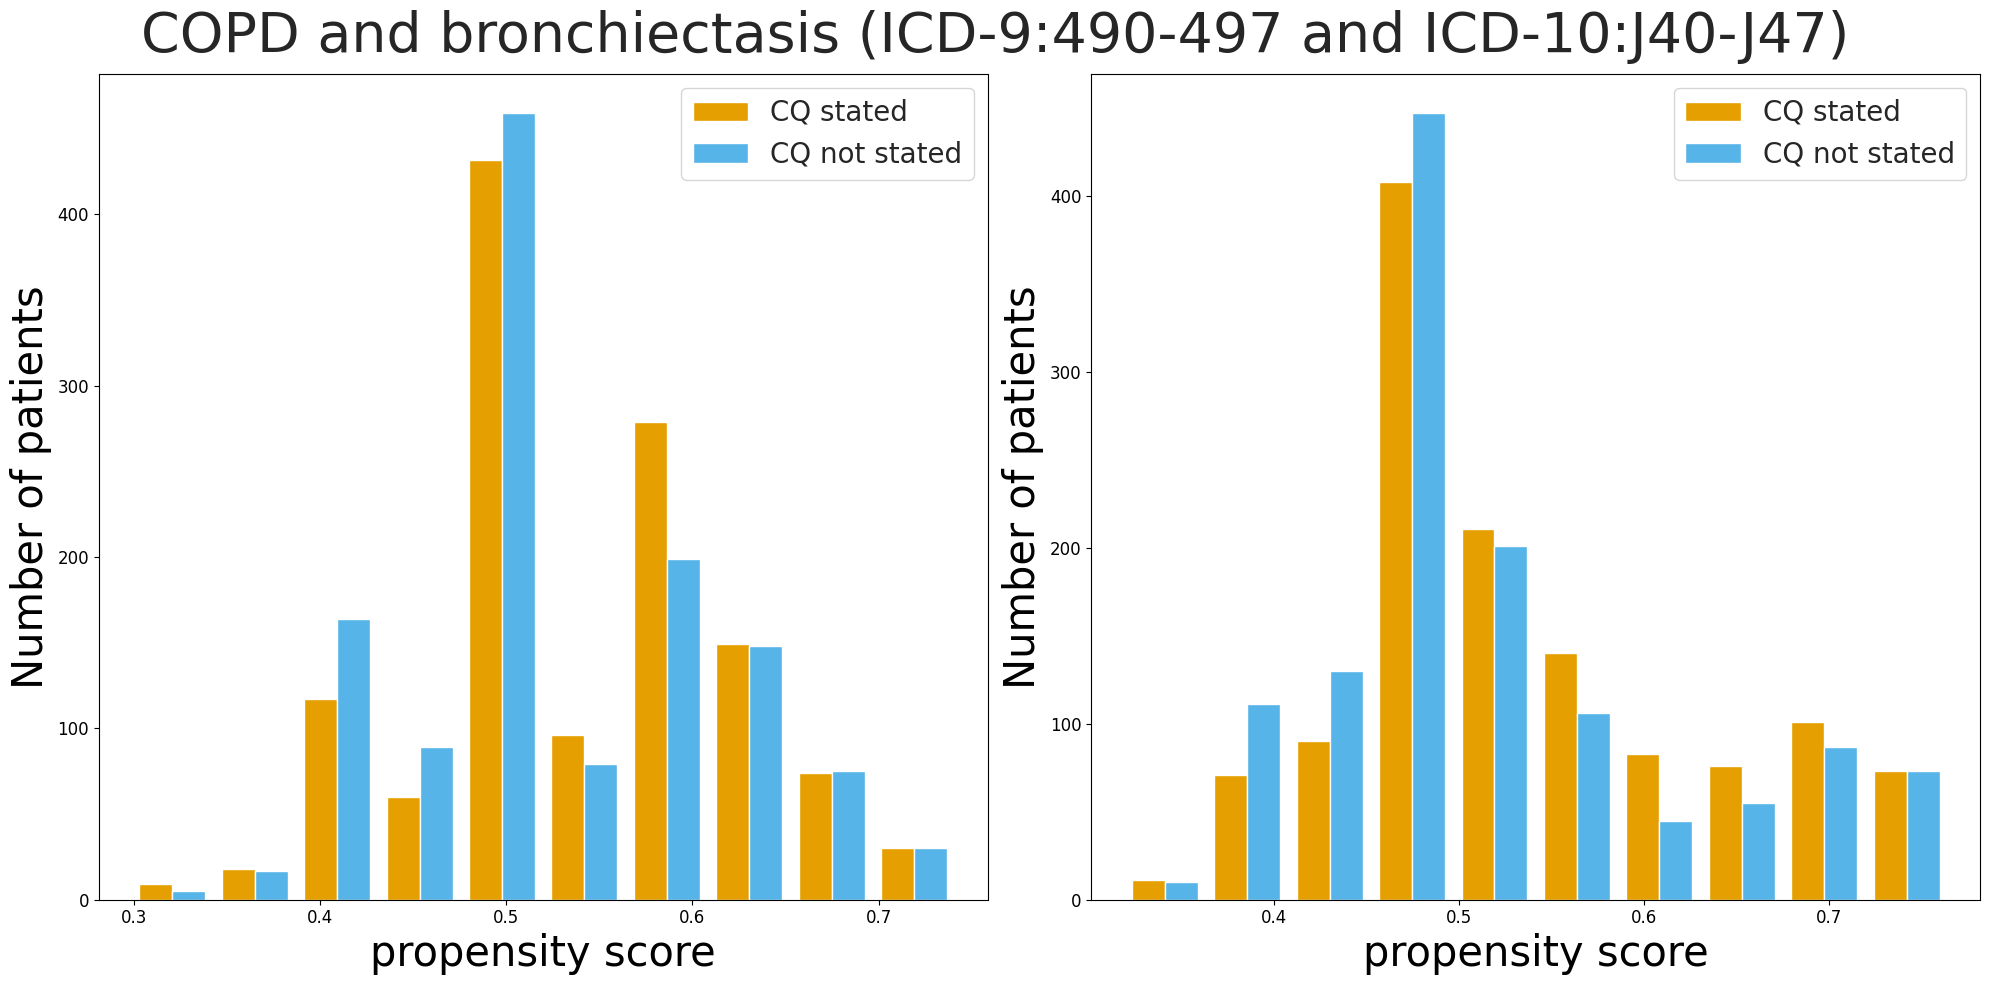

In [64]:
plt.style.use('default')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
psm_helper.psm.plot_match_subplots(Title=title, matched_entity='propensity_score',
                                   Xlabel='propensity score', names=["CQ stated", "CQ not stated"], axes=axes, idx=0)
psm_helper_fu.psm.plot_match_subplots(Title=title, matched_entity='propensity_score', Xlabel='propensity score',
                                      names=["CQ stated", "CQ not stated"], axes=axes, idx=1)
fig.suptitle(title, fontsize=40)
fig.tight_layout()
plt.savefig(f'./plots_ps/{file_name}_1.pdf', dpi=250)

In [65]:
psm_helper.psm_stats_table()

['C0013404', 'C0024117', 'C0010200', 'C0004096', 'C4086268', 'C0242184', 'C0015967', 'C0043144', 'C0008031', 'C0239134', 'C0018802', 'C0332271', 'C0476273', 'C0349790', 'C1145670', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2', 'M', 'F']
                            is_clinical_question_stated  C0013404            \
                                                  count      mean       std   
is_clinical_question_stated                                                   
0                                                  1265  0.483004  0.499909   
1                                                  1264  0.448576  0.497545   

                             C0024117            C0010200            C0004096  \
                                 mean       std      mean       std      mean   
is_clinical_question_stated                                                     
0                            0.156522  0.363493  0.223715  0.416898  0.091700   
1                            0.1

In [67]:
psm_helper_fu.psm_stats_table()

['is_follow_up', 'C0013404', 'C0024117', 'C0010200', 'C0004096', 'C4086268', 'C0242184', 'C0015967', 'C0043144', 'C0008031', 'C0239134', 'C0018802', 'C0332271', 'C0476273', 'C0349790', 'C1145670', 'age_intervall_0', 'age_intervall_1', 'age_intervall_2', 'M', 'F']
                            is_clinical_question_stated is_follow_up  \
                                                  count         mean   
is_clinical_question_stated                                            
0                                                  1265     0.191304   
1                                                  1264     0.239715   

                                       C0013404            C0024117            \
                                  std      mean       std      mean       std   
is_clinical_question_stated                                                     
0                            0.393484  0.483004  0.499909  0.156522  0.363493   
1                            0.427079  0.440665  0.

## Causal effect estimates

### Risk Difference estimation and CI (95%)

In [13]:
def effect_stats_calcluations(test_stats_tmp, psm_helper_tmp):
    significant_pathologies = test_stats_tmp["pathology"].to_list()
    
    effect_estimates = {
        "pathology": [],
        "risk_difference": [],
        "ci": []
    }
    for s_path in significant_pathologies:
        p_1 = psm_helper_tmp.df_matched_treatment[f"{s_path}_is_stated"].mean()
        n_1 = len(psm_helper_tmp.df_matched_treatment[f"{s_path}_is_stated"])
        p_2 = psm_helper_tmp.df_matched_control[f"{s_path}_is_stated"].mean()
        n_2 = len(psm_helper_tmp.df_matched_control[f"{s_path}_is_stated"])
        z_ = 1.96
        
        risk_difference = (p_1 - p_2)
        ci_upper = risk_difference + z_ * np.sqrt(p_1 * (1 - p_1) / n_1 + p_2 * (1 - p_2) / n_2)
        ci_lower = risk_difference - z_ * np.sqrt(p_1 * (1 - p_1) / n_1 + p_2 * (1 - p_2) / n_2)
        
        effect_estimates["pathology"].append(s_path)
        effect_estimates["risk_difference"].append(risk_difference)
        effect_estimates["ci"].append((ci_lower, ci_upper))
    return pd.DataFrame(effect_estimates)

In [50]:
effect_estimates = effect_stats_calcluations(test_stats, psm_helper)
effect_estimates["pathology"].replace("Enlarged_Cardiomediastinum", "Enl. Cardiomed.", inplace=True)
effect_estimates_fu = effect_stats_calcluations(test_stats_fu, psm_helper_fu)
effect_estimates_fu["pathology"].replace("Enlarged_Cardiomediastinum", "Enl. Cardiomed.", inplace=True)
effect_estimates
effect_estimates_fu

,pathology,risk_difference,ci
0,Atelectasis,-0.032258,"(-0.11297458226651007, 0.04845845323425195)"
1,Cardiomegaly,0.118280,"(0.04430749391809145, 0.19225164586685478)"
2,Consolidation,-0.003584,"(-0.0588838489311743, 0.05171539014981228)"
3,Edema,-0.010753,"(-0.07653835059599784, 0.05503297425191178)"
4,Enl. Cardiomed.,0.039427,"(-0.017081800998135485, 0.09593484759311759)"
5,Fracture,-0.028674,"(-0.11042684157811031, 0.053079171327214264)"
6,Lung_Lesion,-0.017921,"(-0.03877281035583216, 0.0029305164490221226)"
7,Lung_Opacity,-0.021505,"(-0.09734770862099322, 0.054336955932821104)"
8,No_Finding,0.007168,"(-0.04845965413614122, 0.06279657169886527)"
9,Pleural_Effusion,-0.017921,"(-0.09942711907940162, 0.06358482517259158)"


In [168]:
plt.style.use('default')

def plot_confidence_interval(ax_, x, effect_point_estimate, ci, color='#619cff', horizontal_line_width=0.25):
    left = x - horizontal_line_width / 2
    top = ci[0]
    right = x + horizontal_line_width / 2
    bottom = ci[1]
    ax_.plot([x, x], [top, bottom], color=color, linewidth=3.0)
    if horizontal_line_width > 0:
        ax_.plot([left, right], [top, top], color=color)
        ax_.plot([left, right], [bottom, bottom], color=color)
    ax_.plot(x, effect_point_estimate, 'o', color='#619cff', markersize=12.0)


def plot_effect_estimates(effect_estimates_tmp, ax_, set_x_lable = True, set_y_label=True):
    offset = 1
    ax_.axhline(y=0.0, color='black', linestyle='--', linewidth=1.0)
    # plt.grid()
    for idx, row in effect_estimates_tmp.iterrows():
        plot_confidence_interval(ax_, offset, row["risk_difference"], row["ci"], horizontal_line_width=0.0)
        offset += 1
    ax_.set_xticks(range(1, len(effect_estimates_tmp)+1), effect_estimates_tmp["pathology"], rotation=90)
    ax_.xaxis.set_tick_params(labelsize=30)
    ax_.yaxis.set_tick_params(labelsize=30)
    ax_.set_xlabel("Pathology") if set_x_lable else ax_.set_xlabel("")
    ax_.set_ylabel("Risk difference") if set_y_label else ax_.set_ylabel("")
    ax_.xaxis.label.set_size(30)
    ax_.yaxis.label.set_size(30)

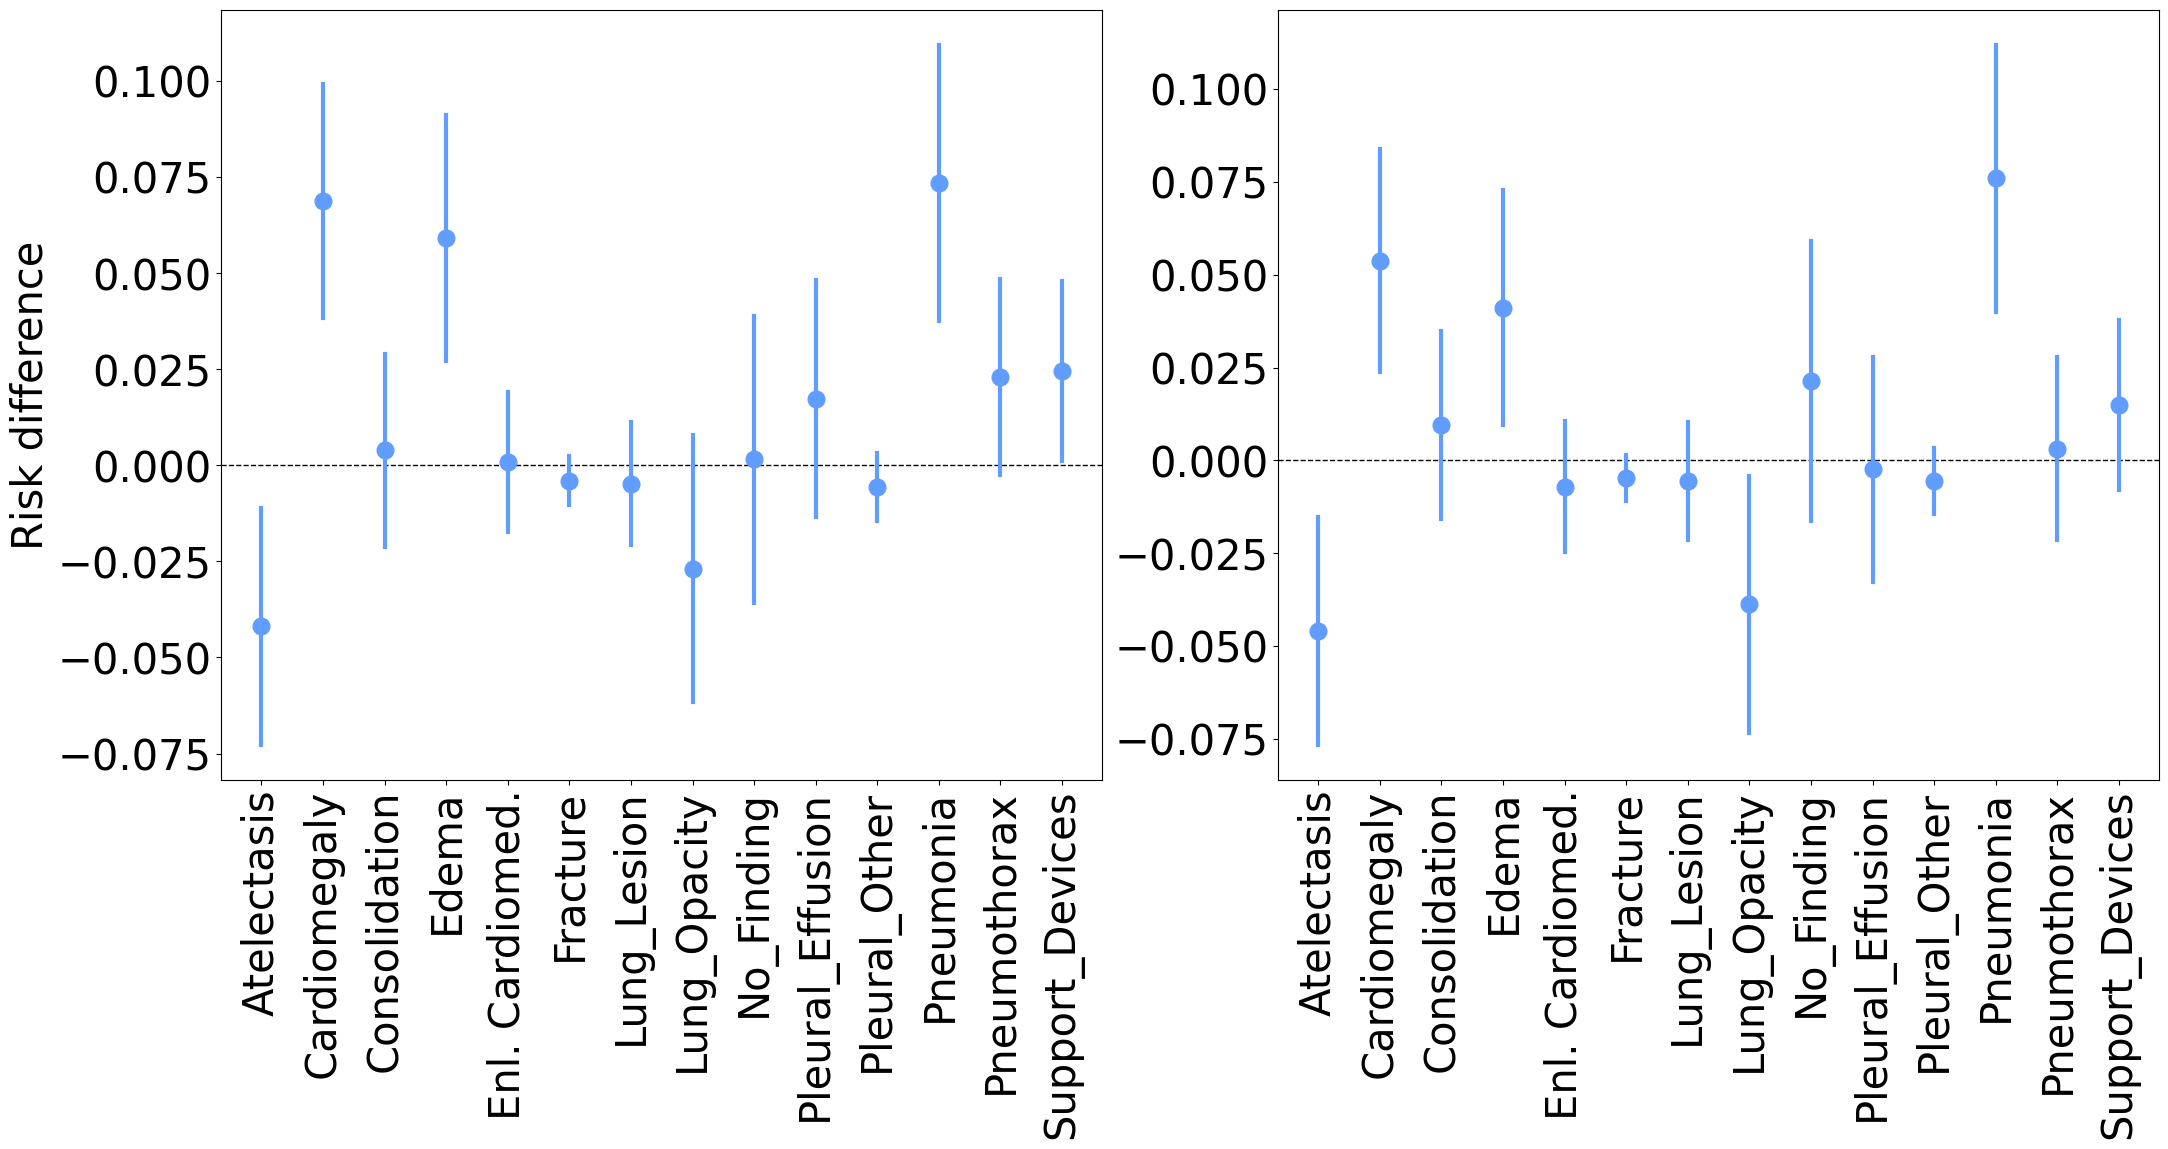

In [169]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
plot_effect_estimates(effect_estimates.copy(deep=True), ax[0], set_x_lable=False)
plot_effect_estimates(effect_estimates_fu.copy(deep=True), ax[1], set_x_lable=False, set_y_label=False)

plt.savefig(f"./plots_effect/{title}_combi_unordered.pdf", dpi=250, bbox_inches="tight")
plt.show()

## Sensitivity Analysis

In [12]:
%%time
# test_stats_dict = dict.fromkeys(OBSERVATIONAL_CLASSES, [])
test_stats_dict = {
    "run_id": [],
    "pathology": [],
    "chi2": [],
    "p_value": [],
    "is_significant": []
}
print(f"./tmp/df_{title}.pkl")
if os.path.isfile(f"./tmp/df_{title}.pkl"):
    df_test_stats = pd.read_pickle(f"./tmp/df_{title}.pkl")
else:
    for run_id, symptoms in enumerate(observation_indication_history):
        symptoms_list = observation_indication_history_cuis[0:(run_id + 1)]
        print("(", run_id, ")", " Estimation for: ", symptoms_list)
    
        psm_helper = PsmHelper(data=df_data,
                               patient_characteristics=patient_characteristics,
                               custom_confounders=[],
                               indication_cuis=observation_indication_history_cuis[0:(run_id + 1)],
                               treatment_var=treatment_var,
                               spec_cq_cui=None,
                               follow_up_filter=None)
        psm_helper.generate_psm_data(icd_code=disease_icd,
                                     apply_cond_filter=False)
        psm_helper.psmpy_prop_score_log_reg()
        psm_helper.psmpy_knn(matcher="propensity_score",
                             replacement=False)
        test_stats = psm_helper.psmpy_chi2_test_results()
    
        for idx, row in test_stats.iterrows():
            test_stats_dict["run_id"].append(run_id)
            test_stats_dict["pathology"].append(row["pathology"])
            test_stats_dict["chi2"].append(row["chi2"])
            test_stats_dict["p_value"].append(row["p_value"])
            test_stats_dict["is_significant"].append(row["is_significant"])
    df_test_stats = pd.DataFrame(test_stats_dict)
    df_test_stats.to_pickle(f"./tmp/df_{title}.pkl")

./tmp/df_Pneumonia(486-J18.9).pkl
CPU times: user 1.27 ms, sys: 1.06 ms, total: 2.32 ms
Wall time: 6.17 ms


In [13]:
%%time
# test_stats_dict = dict.fromkeys(OBSERVATIONAL_CLASSES, [])
test_stats_dict_fu = {
    "run_id": [],
    "pathology": [],
    "chi2": [],
    "p_value": [],
    "is_significant": []
}

if os.path.isfile(f"./tmp/df_{title}_fu.pkl"):
    df_test_stats_fu = pd.read_pickle(f"./tmp/df_{title}_fu.pkl")
else:
    for run_id, symptoms in enumerate(observation_indication_history):
        symptoms_list = observation_indication_history_cuis[0:(run_id + 1)]
        print("(", run_id, ")", " Estimation for: ", symptoms_list)
        
        # follow-up filter
        follow_up_filter: FollowUpFilter = {"UNIQUE_HADM_ID": True,
                                            "MIN_EXAMS_DURING_UNIQUE_HADM_ID": 1000}  # MIN_EXAMS_DURING_UNIQUE_HADM_ID -> legacy, not used anymore
        # init psm helper
        psm_helper_fu = PsmHelper(data=df_data,
                                  patient_characteristics=patient_characteristics,
                                  custom_confounders=[],
                                  indication_cuis=observation_indication_history_cuis[0:(run_id + 1)],
                                  treatment_var=treatment_var,
                                  spec_cq_cui=None,
                                  # follow_up_filter=None)
                                  follow_up_filter=follow_up_filter)
        psm_helper_fu.generate_psm_data(icd_code=disease_icd,
                                        apply_cond_filter=False)
    
        psm_helper_fu.psmpy_prop_score_log_reg()
        psm_helper_fu.psmpy_knn(matcher="propensity_score",
                             replacement=False)
        test_stats = psm_helper_fu.psmpy_chi2_test_results()
    
        for idx, row in test_stats.iterrows():
            test_stats_dict_fu["run_id"].append(run_id)
            test_stats_dict_fu["pathology"].append(row["pathology"])
            test_stats_dict_fu["chi2"].append(row["chi2"])
            test_stats_dict_fu["p_value"].append(row["p_value"])
            test_stats_dict_fu["is_significant"].append(row["is_significant"])
    
    df_test_stats_fu = pd.DataFrame(test_stats_dict_fu)
    df_test_stats_fu.to_pickle(f"./tmp/df_{title}_fu.pkl")

CPU times: user 632 µs, sys: 918 µs, total: 1.55 ms
Wall time: 975 µs


In [14]:
df_plot_p_value = pd.pivot(df_test_stats[["run_id", "pathology", "p_value"]], index="run_id", columns="pathology",
                           values="p_value")
df_plot_chi2 = pd.pivot(df_test_stats[["run_id", "pathology", "chi2"]], index="run_id", columns="pathology",
                        values="chi2")
df_plot_is_significant = pd.pivot(df_test_stats[["run_id", "pathology", "is_significant"]], index="run_id",
                                  columns="pathology", values="is_significant")
df_plot_p_value.rename(columns={"Enlarged_Cardiomediastinum": "Enl. Cardiomed."}, inplace=True)
df_plot_is_significant.rename(columns={"Enlarged_Cardiomediastinum": "Enl. Cardiomed."}, inplace=True)
df_plot_p_value

pathology,Atelectasis,Cardiomegaly,Consolidation,Edema,Enl. Cardiomed.,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
run_id,,,,,,,,,,,,,,
0,0.377261,0.000004,0.327723,0.825530,1.000000,0.402181,0.229040,0.001771,0.531352,0.000002,0.436712,1.285706e-08,3.670190e-08,0.000219
1,0.508794,0.000004,0.408616,0.790153,0.642246,0.520681,0.299897,0.006206,0.315400,0.000012,0.344945,1.121118e-06,6.354858e-07,0.001352
2,0.231762,0.000102,0.380372,0.562936,0.345199,0.402181,0.198218,0.009856,0.436384,0.000924,0.344945,2.212757e-05,4.170269e-05,0.018818
3,0.288468,0.000049,0.167186,0.964706,0.642246,0.227914,0.198218,0.021000,0.582896,0.000518,0.344945,3.131121e-05,2.701510e-05,0.012350
4,0.198579,0.000071,0.200138,0.824581,0.586856,0.227914,0.198218,0.021000,0.482476,0.000447,0.344945,3.131121e-05,6.386910e-05,0.014241
5,0.249728,0.000059,0.183100,0.859318,0.482476,0.227914,0.170393,0.021000,0.436384,0.000924,0.344945,3.716672e-05,2.665554e-04,0.032038
6,0.198579,0.000176,0.113967,1.000000,0.305192,0.227914,0.198218,0.045938,0.393155,0.003558,0.344945,4.756274e-04,1.006017e-03,0.142598
7,0.168958,0.000071,0.152358,0.825530,0.345199,0.402181,0.170393,0.041853,0.531352,0.005185,0.436712,8.497988e-04,6.955573e-04,0.052721
8,0.231762,0.000071,0.138575,0.894682,0.482476,0.402181,0.170393,0.055121,0.436384,0.003558,0.436712,7.365970e-04,5.765398e-04,0.059393


In [156]:
df_plot_p_value_fu = pd.pivot(df_test_stats_fu[["run_id", "pathology", "p_value"]], index="run_id", columns="pathology",
                           values="p_value")
df_plot_chi2_fu = pd.pivot(df_test_stats_fu[["run_id", "pathology", "chi2"]], index="run_id", columns="pathology",
                        values="chi2")
df_plot_is_significant_fu = pd.pivot(df_test_stats_fu[["run_id", "pathology", "is_significant"]], index="run_id",
                                  columns="pathology", values="is_significant")
df_plot_p_value_fu.rename(columns={"Enlarged_Cardiomediastinum": "Enl. Cardiomed."}, inplace=True)
df_plot_is_significant_fu.rename(columns={"Enlarged_Cardiomediastinum": "Enl. Cardiomed."}, inplace=True)
df_plot_p_value_fu

pathology,Atelectasis,Cardiomegaly,Consolidation,Edema,Enl. Cardiomed.,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
run_id,,,,,,,,,,,,,,
0,0.010532,0.002678,0.393986,0.012470,0.728847,0.209852,0.773708,0.089969,0.386747,0.758485,0.495967,0.000046,0.653234,0.374169
1,0.010532,0.001931,0.302660,0.010904,0.863292,0.060652,0.494971,0.048993,0.409655,0.918635,0.387965,0.000078,0.949628,0.248740
2,0.009054,0.006813,0.427988,0.026830,0.795534,0.120231,0.560288,0.048993,0.364647,0.758485,0.293100,0.000093,0.749060,0.339457
3,0.009054,0.003145,0.227188,0.010904,0.728847,0.209852,0.700249,0.074031,0.386747,0.918635,0.387965,0.000093,0.848278,0.491739
4,0.004078,0.003686,0.393986,0.016219,0.863292,0.209852,0.628901,0.054476,0.284428,0.918635,0.495967,0.000065,1.000000,0.276772
5,0.003447,0.003686,0.393986,0.006257,0.482194,0.209852,0.494971,0.039395,0.284428,0.758485,0.293100,0.000055,0.700629,0.177195
6,0.004810,0.002276,0.393986,0.010904,0.600628,0.209852,0.560288,0.060456,0.266417,0.643824,0.293100,0.000046,0.653234,0.177195
7,0.004810,0.003145,0.361758,0.010904,0.482194,0.209852,0.560288,0.035223,0.249214,0.643824,0.293100,0.000032,0.798342,0.199025
8,0.006636,0.001381,0.393986,0.012470,0.663724,0.209852,0.494971,0.031430,0.303254,0.681335,0.387965,0.000027,0.562240,0.199025


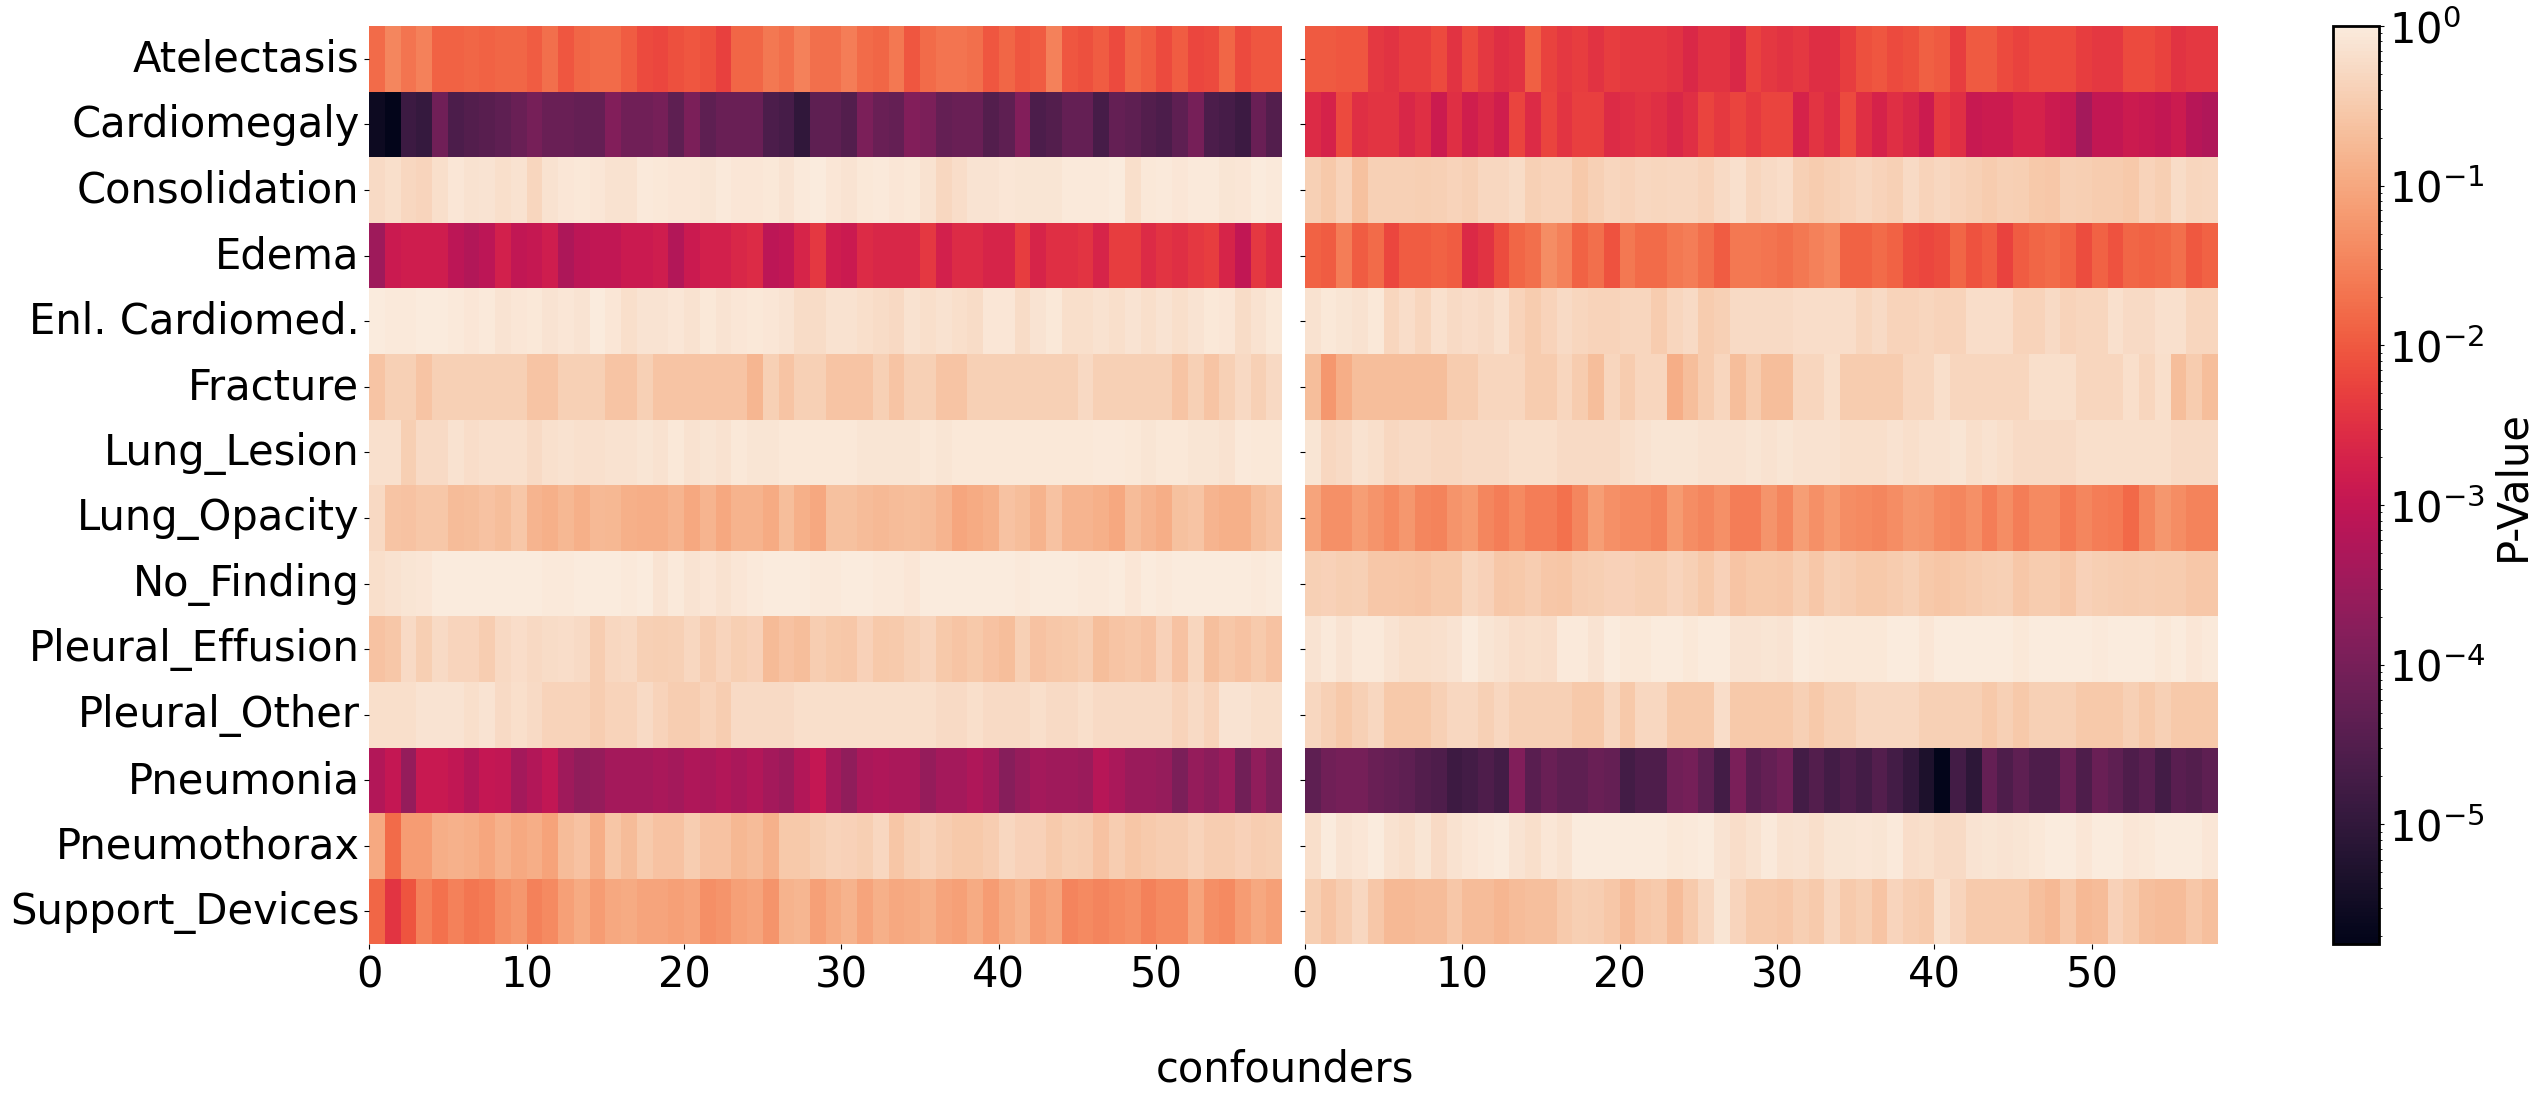

In [157]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,2, figsize=(30, 10), sharey=True, sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
# ax = sns.heatmap(df_plot_p_value.T, cmap="viridis_r", norm=LogNorm(vmin=df_plot_p_value.values.min(), vmax=df_plot_p_value.values.max()))
# ax = sns.heatmap(df_plot_p_value.T, cmap="rocket_r", norm=LogNorm(vmin=df_plot_p_value.values.min(), vmax=df_plot_p_value.values.max()))
# ax = sns.heatmap(df_plot_p_value.T, cmap="rocket_r", norm=LogNorm(vmin=df_plot_p_value.values.min(), vmax=0.5))
sns.heatmap(df_plot_p_value.T, cmap="rocket", cbar=False, cbar_ax=None, norm=LogNorm(vmin=df_plot_p_value.values.min(), vmax=1), ax=ax[0])
sns.heatmap(df_plot_p_value_fu.T, cmap="rocket", cbar=False, cbar_ax=None, norm=LogNorm(vmin=df_plot_p_value_fu.values.min(), vmax=1), ax=ax[1])

ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")

ax[0].xaxis.set_tick_params(labelsize=30)
ax[0].yaxis.set_tick_params(labelsize=30)
ax[0].set_xticks(range(0, len(df_plot_p_value)+1, 10), range(0, len(df_plot_p_value)+1, 10))
ax[1].set_xticks(range(0, len(df_plot_p_value)+1, 10), range(0, len(df_plot_p_value)+1, 10))
ax[1].xaxis.set_tick_params(labelsize=30)
ax[1].yaxis.set_tick_params(labelsize=30)

# ax[1].set_yticklabels([])
# ax = sns.heatmap(df_plot_p_value.T, cmap="rocket_r")
fig.tight_layout(rect=[0, 0, .9, 1])
cbar = fig.colorbar(ax[1].collections[0], ax=ax, orientation='vertical')
cbar.outline.set_color("black")
cbar.outline.set_linewidth(2)
cbar.set_label('P-Value', size=30)
cbar.ax.tick_params(labelsize=30)
fig.text(0.43, -0.07, 'confounders', ha='center', size=30)
plt.savefig(f"./plots_sensitivity/{title}_p_val.pdf", dpi=250, bbox_inches="tight")
plt.show()

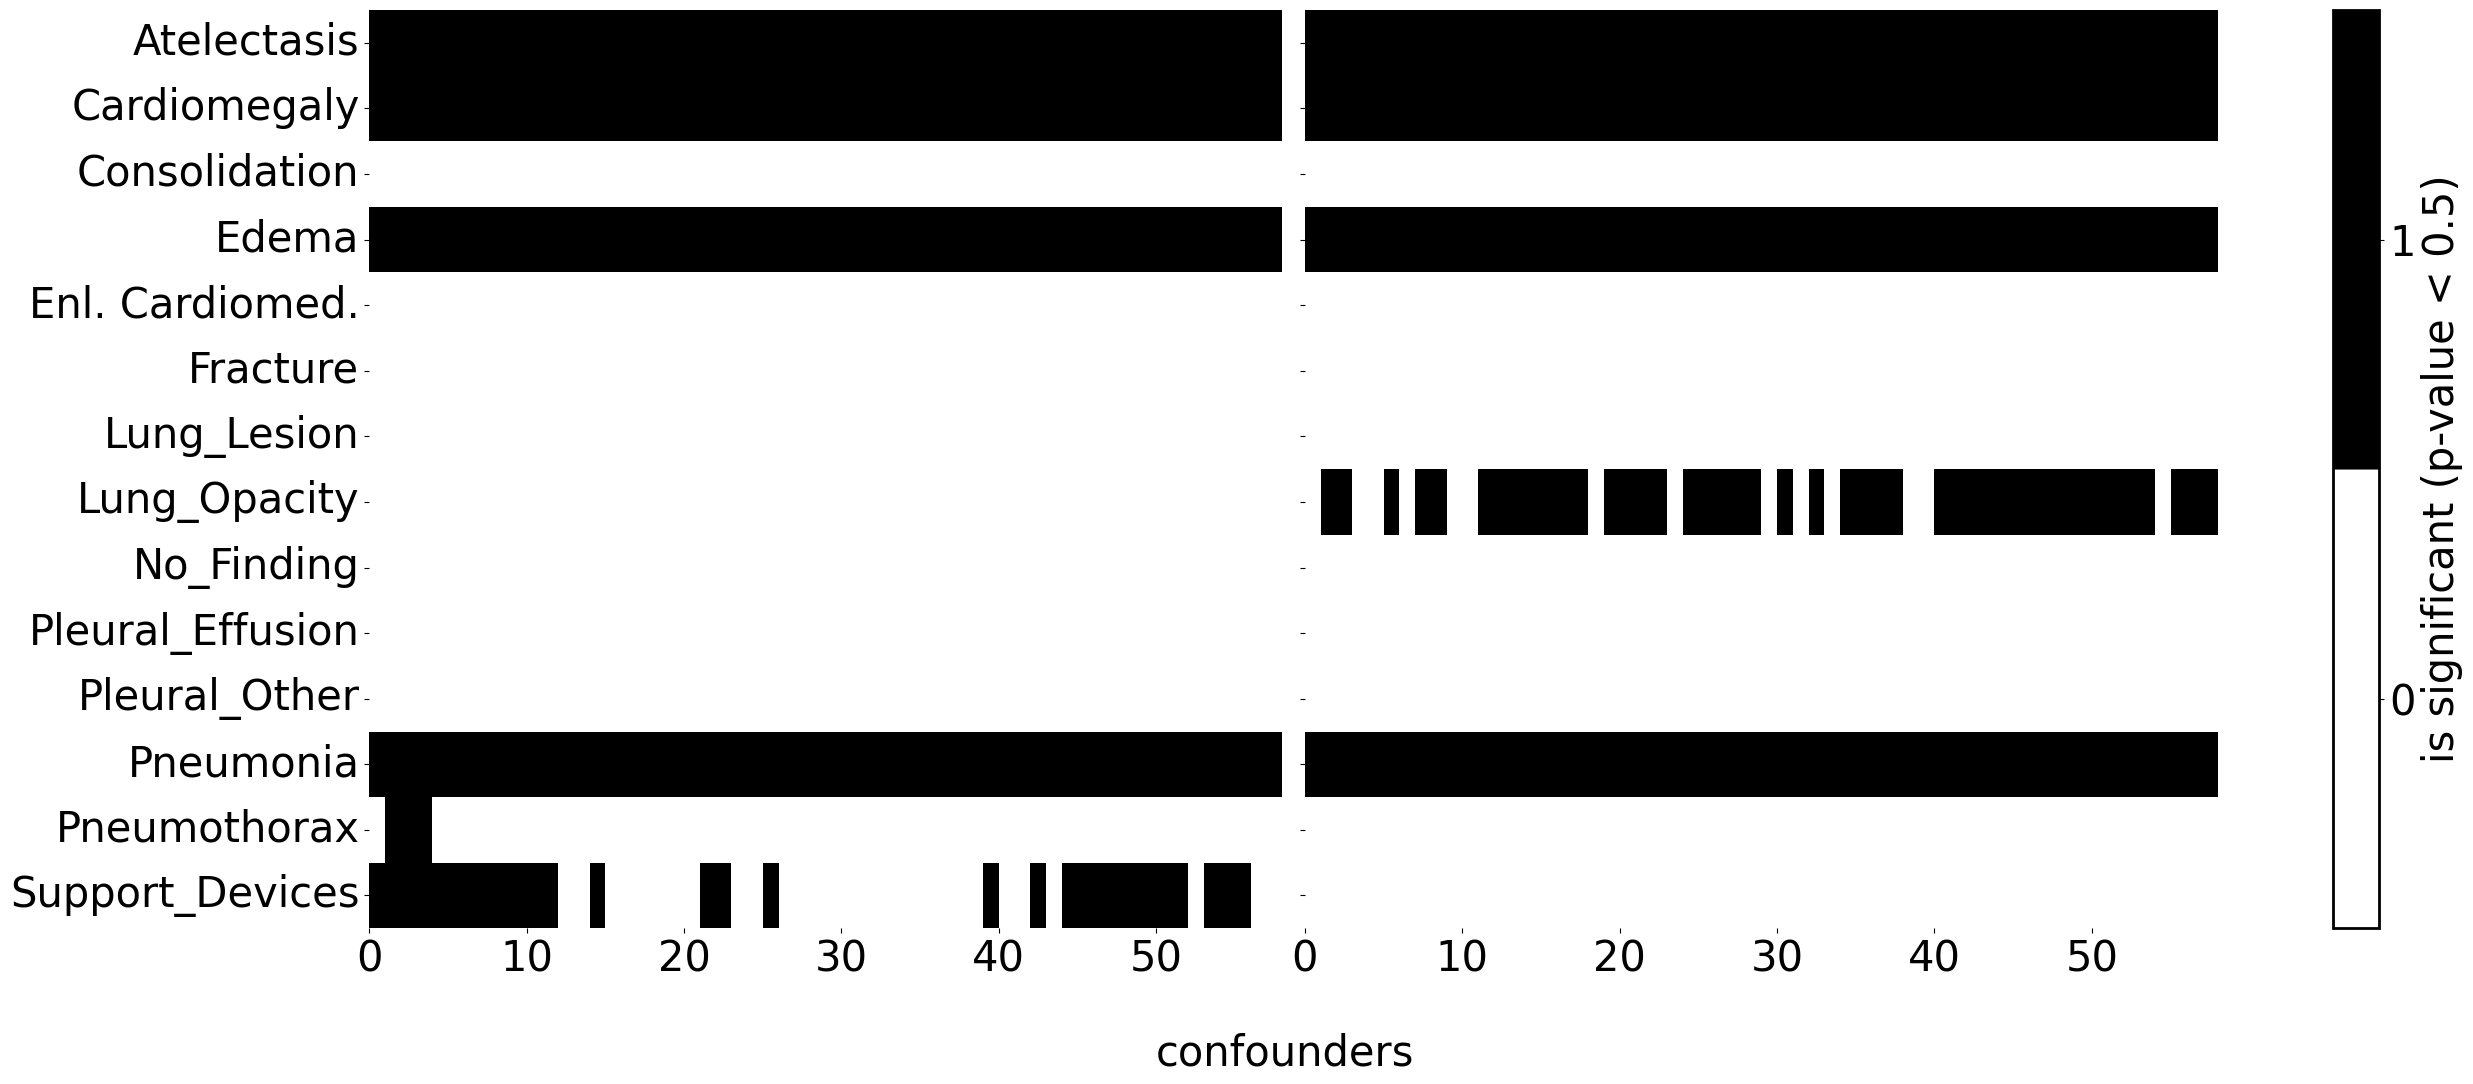

In [158]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1,2, figsize=(30, 10), sharey=True, sharex=True)

# Define custom colormap with black and white colors
cmap_binary = mcolors.ListedColormap(['white', 'black'])

# sns.heatmap(df_plot_is_significant.T, cmap="binary", cbar=False, cbar_ax=None, linewidth=0.0, ax=ax[0])
# sns.heatmap(df_plot_is_significant_fu.T, cmap="binary", cbar=False, cbar_ax=None, linewidth=0.0, ax=ax[1])
sns.heatmap(df_plot_is_significant.T, cmap=cmap_binary, cbar=False, cbar_ax=None, linewidth=0.0, ax=ax[0])
sns.heatmap(df_plot_is_significant_fu.T, cmap=cmap_binary, cbar=False, cbar_ax=None, linewidth=0.0, ax=ax[1])
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")

ax[0].xaxis.set_tick_params(labelsize=30)
ax[0].yaxis.set_tick_params(labelsize=30)
ax[0].set_xticks(range(0, len(df_plot_p_value)+1, 10), range(0, len(df_plot_p_value)+1, 10))
ax[1].set_xticks(range(0, len(df_plot_p_value)+1, 10), range(0, len(df_plot_p_value)+1, 10))
ax[1].xaxis.set_tick_params(labelsize=30)
ax[1].yaxis.set_tick_params(labelsize=30)

fig.tight_layout(rect=[0, 0, .9, 1])
cbar = fig.colorbar(ax[1].collections[0], ax=ax, orientation='vertical', drawedges=True)
cbar.outline.set_color("black")
cbar.outline.set_linewidth(2)
cbar.set_label('is significant (p-value < 0.5)', size=30)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['0', '1'])
cbar.ax.tick_params(labelsize=30)
fig.text(0.43, -0.07, 'confounders', ha='center', size=30)

plt.savefig(f"./plots_sensitivity/{title}_bin_sig.pdf", dpi=250, bbox_inches="tight")
plt.show()